In [1]:
import sys
sys.path.append('/mnt/nas05/data01/francesco/progetto_simone/ionosphere')

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import seaborn as sns
from src.data.dataset import IonoSequenceDataset
from tqdm import tqdm

sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (15, 10)

/mnt/nas05/data01/francesco/progetto_simone/ionosphere/src/vit.py:26: FutureWarning: xformers.components is deprecated and is not maintained anymore. It might be removed in a future version of xFormers 
  import xformers.components.attention.core as xfa


In [2]:
# Configuration
csv_path = "/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/l1_earth_associated_with_maps.csv"
sequence_length = 30
min_center_distance = 5

In [3]:
# Load dataset with mean_sigma_tanh normalization
print("Loading dataset with mean_sigma_tanh normalization...")
dataset_tanh = IonoSequenceDataset(
    csv_path=csv_path,
    transform_cond_csv=None,
    sequence_length=sequence_length,
    split='train',
    transforms=True,
    normalization_type="absolute_max",
    use_l1_conditions=True,
    min_center_distance=min_center_distance,
    seed=42
)

print(f"\nDataset size (mean_sigma_tanh): {len(dataset_tanh)} sequences")
if dataset_tanh.normalizer is not None:
    stats = dataset_tanh.normalizer.get_stats()
    print(f"Normalizer mean: {stats['mean']:.2f}")
    print(f"Normalizer std: {stats['std']:.2f}")

Loading dataset with mean_sigma_tanh normalization...

Dataset size (mean_sigma_tanh): 29124 sequences


In [4]:
dataset_tanh.cond_max

array([  25.8 ,   73.45,   64.24, -252.9 ], dtype=float32)

In [5]:
df = pd.read_csv(csv_path)
print("Vx statistics from CSV:")
print(df['proton_vx_gsm'].describe())
print("\nAny values outside range [-821.7, -252.9]?")
print("Values > -252.9:", (df['proton_vx_gsm'] > -252.9).sum())
print("Values < -821.7:", (df['proton_vx_gsm'] < -821.7).sum())

Vx statistics from CSV:
count    214927.000000
mean       -421.878501
std          62.249370
min        -821.700000
25%        -464.500000
50%        -422.900000
75%        -382.000000
max        -252.900000
Name: proton_vx_gsm, dtype: float64

Any values outside range [-821.7, -252.9]?
Values > -252.9: 0
Values < -821.7: 0


In [25]:
import pandas as pd
from datetime import datetime, timedelta

# Create timestamps for entire year 2024 with 2-minute cadence
start_time = datetime(2024, 1, 1, 0, 0, 0)
end_time = datetime(2024, 12, 31, 23, 59, 59)

# Generate timestamps every 2 minutes
timestamps_2024 = pd.date_range(start=start_time, end=end_time, freq='2min')

In [26]:
len(timestamps_2024)

263520

In [28]:
print('Percentage of timestamps in 2024 present in dataset: ',
      100 * sum(ts in timestamps_2024 for ts in df['time_map']) / len(timestamps_2024))

Percentage of timestamps in 2024 present in dataset:  81.56003339404978


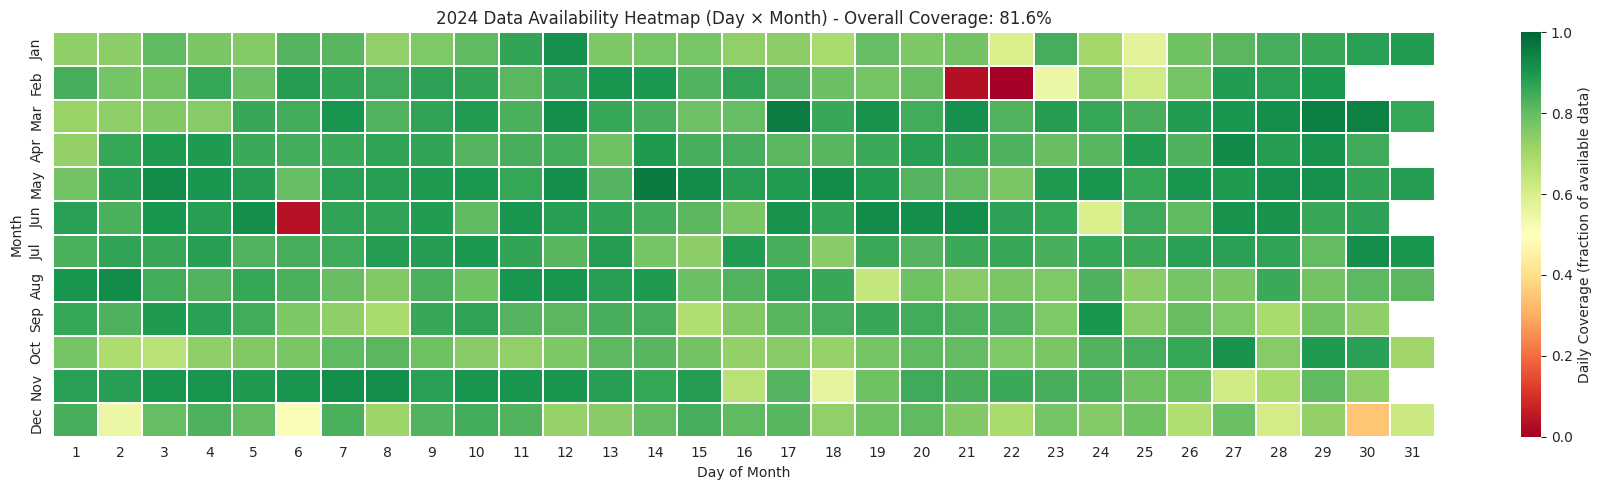


Data Availability Statistics:
Total expected timestamps (2-min cadence): 263,520
Total available timestamps: 214,927
Overall coverage: 81.56%

Daily coverage statistics:
  Best day: 96.0%
  Worst day: 0.0%
  Average: 81.6%
  Days with 100% coverage: 0
  Days with <50% coverage: 4


In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from datetime import datetime

# Load your data
csv_path = "/mnt/nas05/data01/francesco/sdo_img2img/sde_mag2mag_v2/progetto_simone/data/l1_earth_associated_with_maps.csv"
df = pd.read_csv(csv_path)
df['time_map'] = pd.to_datetime(df['time_map'])

# Create full 2024 timestamps with 2-min cadence
start_time = datetime(2024, 1, 1, 0, 0, 0)
end_time = datetime(2024, 12, 31, 23, 59, 59)
timestamps_2024 = pd.date_range(start=start_time, end=end_time, freq='2min')

# Create availability dataframe
df_availability = pd.DataFrame({'time': timestamps_2024})
df_availability["has_data"] = df_availability["time"].isin(df['time_map'])

# Compute daily coverage ratio
df_availability["date"] = df_availability["time"].dt.date
daily_cov = (
    df_availability.groupby("date")["has_data"]
    .mean()
    .reset_index(name="coverage_ratio")
)

# Extract month/day for heatmap axes
daily_cov["month"] = pd.to_datetime(daily_cov["date"]).dt.month_name().str[:3]
daily_cov["day"] = pd.to_datetime(daily_cov["date"]).dt.day

# Pivot for heatmap
heatmap_data = daily_cov.pivot_table(index="month", columns="day", values="coverage_ratio")

# Reorder months
month_order = ["Jan", "Feb", "Mar", "Apr", "May", "Jun", "Jul", "Aug", "Sep", "Oct", "Nov", "Dec"]
heatmap_data = heatmap_data.reindex(month_order)

# Create heatmap
plt.figure(figsize=(18, 5))
sns.heatmap(
    heatmap_data,
    cmap="RdYlGn",
    linewidths=0.1,
    cbar_kws={"label": "Daily Coverage (fraction of available data)"},
    vmin=0, vmax=1,
    annot=False
)
plt.title(f"2024 Data Availability Heatmap (Day × Month) - Overall Coverage: {df_availability['has_data'].mean()*100:.1f}%")
plt.xlabel("Day of Month")
plt.ylabel("Month")
plt.tight_layout()
plt.show()

# Print some statistics
print(f"\nData Availability Statistics:")
print(f"Total expected timestamps (2-min cadence): {len(timestamps_2024):,}")
print(f"Total available timestamps: {len(df):,}")
print(f"Overall coverage: {df_availability['has_data'].mean()*100:.2f}%")
print(f"\nDaily coverage statistics:")
print(f"  Best day: {daily_cov['coverage_ratio'].max()*100:.1f}%")
print(f"  Worst day: {daily_cov['coverage_ratio'].min()*100:.1f}%")
print(f"  Average: {daily_cov['coverage_ratio'].mean()*100:.1f}%")
print(f"  Days with 100% coverage: {(daily_cov['coverage_ratio'] == 1.0).sum()}")
print(f"  Days with <50% coverage: {(daily_cov['coverage_ratio'] < 0.5).sum()}")

In [6]:
l1_cols = ['proton_vx_gsm', 'bx_gsm', 'by_gsm', 'bz_gsm']
df_clean = df[l1_cols].replace(-99999, np.nan)  # Replace missing values with NaN
cond_min = df_clean.min().values.astype(np.float32)  # min ignores NaN
cond_max = df_clean.max().values.astype(np.float32)  # max ignores NaN

In [7]:
print('Condition mins:', cond_min)
print('Condition maxs:', cond_max)

Condition mins: [-821.7   -32.58  -71.9   -50.93]
Condition maxs: [-252.9    25.8    73.45   64.24]


In [4]:
len(dataset_tanh)

29124

In [20]:
import random
random_idx = random.randint(0, len(dataset_tanh) - 1)
sequence_tanh, conds_tanh = dataset_tanh[random_idx]

In [21]:
sequence_tanh.shape, conds_tanh.shape

(torch.Size([30, 1, 24, 360]), torch.Size([30, 4]))

In [22]:
conds_tanh

tensor([[ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 2.0000,  2.0000,  2.0000,  2.0000],
        [ 0.3217, -0.0562, -0.0803,  0.2911],
        [ 0.3272, -0.0544, -0.0807,  0.2922],
        [ 0.2987, -0.0753, -0.0822,  0.2823],
        [ 0.3124, -0.0768, -0.1053,  0.2841],
        [ 0.3176, -0.0669, -0.1387,  0.2866],
        [ 0.3049, -0.0547, -0.1414,  0.2848],
        [ 0.3118, -0.0497, -0.1545,  0.2880],
        [ 0.3059, -0.0518, -0.1578,  0.2802],
        [ 0.3104, -0.0477, -0.1658

In [19]:
conds_tanh.max()

tensor(2.)

In [17]:
stats_video = {
    "mean": sequence_tanh.mean().item(),
    "std": sequence_tanh.std().item(),
    "min": sequence_tanh.min().item(),
    "max": sequence_tanh.max().item(),
    "per_frame_mean": sequence_tanh.mean(dim=(1, 2, 3)).numpy(),
    "per_frame_std": sequence_tanh.std(dim=(1, 2, 3)).numpy()
}

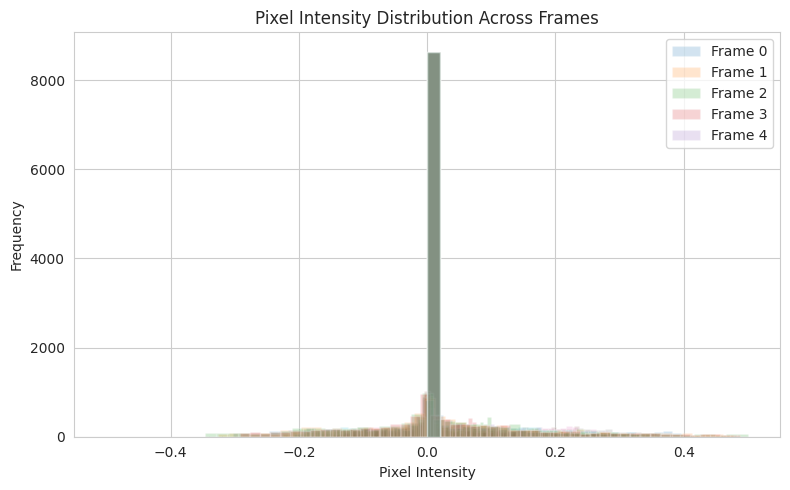

In [18]:
import torch
import matplotlib.pyplot as plt

# Example tensor (replace with your real data)
video = sequence_tanh # (frames, channels, H, W)

# Flatten each frame (remove channel dim)
frames = video[:, 0, :, :].reshape(30, -1)  # shape: (30, H*W)

plt.figure(figsize=(8, 5))

# Plot each frame's histogram on the same plot
for i in range(frames.shape[0]):
    plt.hist(frames[i].numpy().ravel(), bins=50, alpha=0.2, label=f"Frame {i}" if i < 5 else "")  
    # alpha controls transparency; label only first few to avoid clutter

plt.title("Pixel Intensity Distribution Across Frames")
plt.xlabel("Pixel Intensity")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()



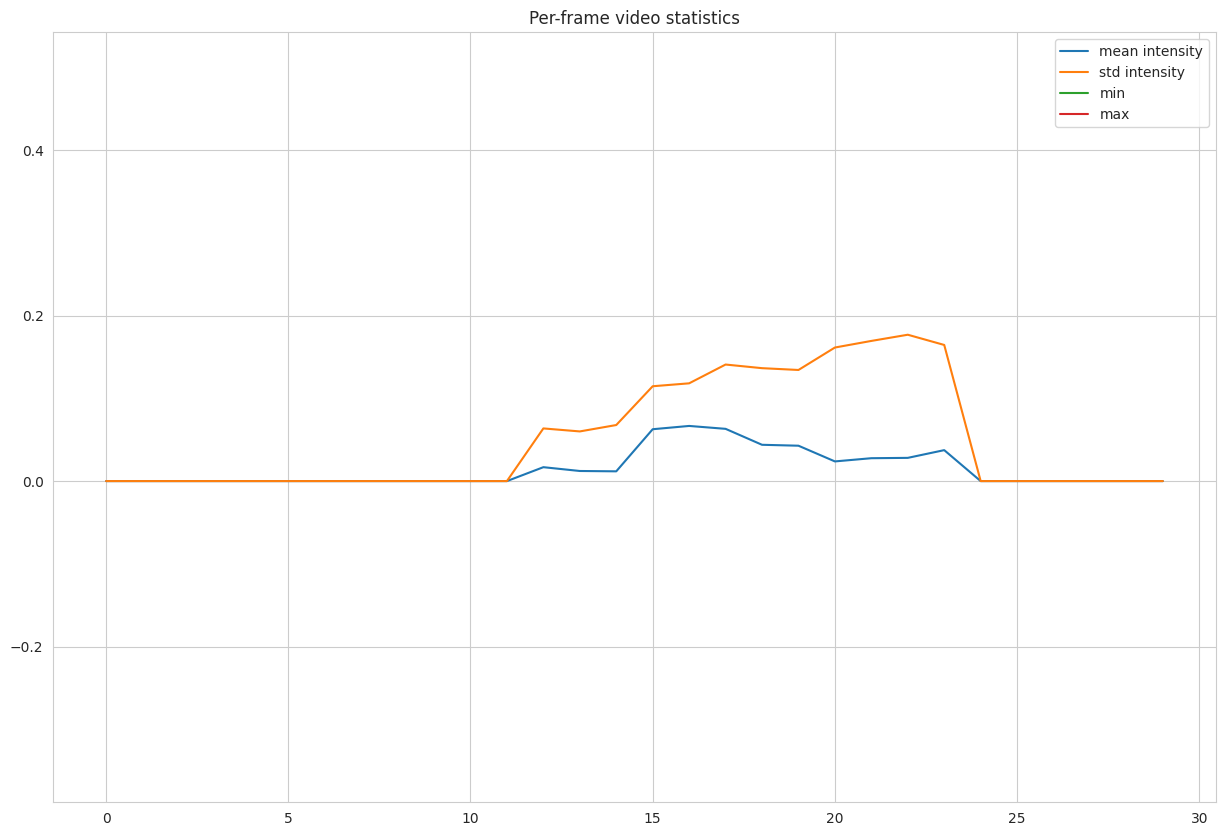

In [19]:
import matplotlib.pyplot as plt

plt.plot(stats_video["per_frame_mean"], label="mean intensity")
plt.plot(stats_video["per_frame_std"], label="std intensity")
plt.plot(stats_video["min"], label="min")
plt.plot(stats_video["max"], label="max")
plt.legend()
plt.title("Per-frame video statistics")
plt.show()